Epoch 1/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 187s 17ms/step - accuracy: 0.9323 - loss: 0.2080 - val_accuracy: 0.9557 - val_loss: 0.1130 - learning_rate: 1.0000e-04
Epoch 2/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 182s 17ms/step - accuracy: 0.9548 - loss: 0.1183 - val_accuracy: 0.9582 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 3/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 182s 17ms/step - accuracy: 0.9582 - loss: 0.1090 - val_accuracy: 0.9602 - val_loss: 0.1024 - learning_rate: 1.0000e-04
Epoch 4/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 204s 17ms/step - accuracy: 0.9606 - loss: 0.1024 - val_accuracy: 0.9626 - val_loss: 0.0945 - learning_rate: 1.0000e-04
Epoch 5/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 184s 17ms/step - accuracy: 0.9627 - loss: 0.0968 - val_accuracy: 0.9648 - val_loss: 0.0900 - learning_rate: 1.0000e-04
Epoch 6/50
10693/10693 ━━━━━━━━━━━━━━━━━━━━ 201s 17ms/step - accuracy: 0.9643 - loss: 0.0918 - val_accuracy: 0.9643 - val_loss: 0.0894 - learning_rate: 1.0000e-04
Epoch 7/50
10693/10693

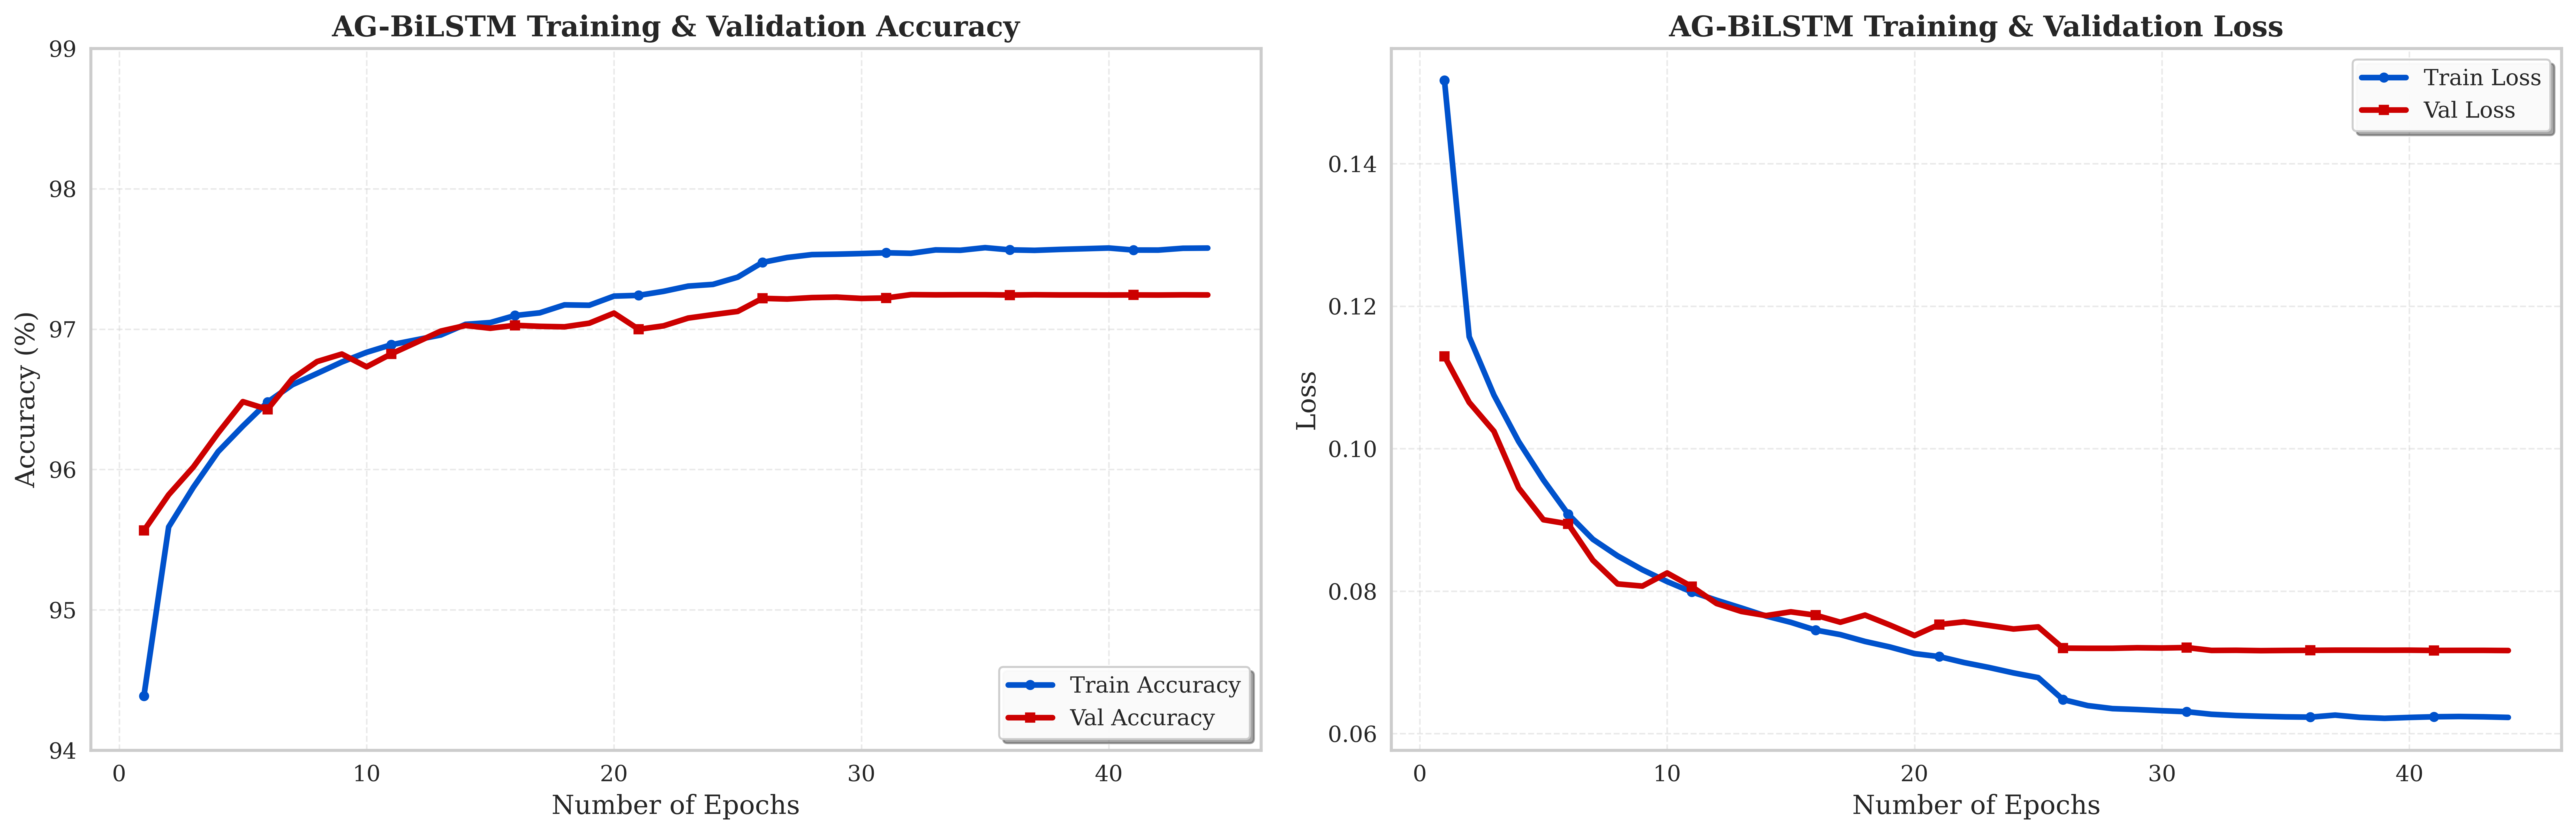

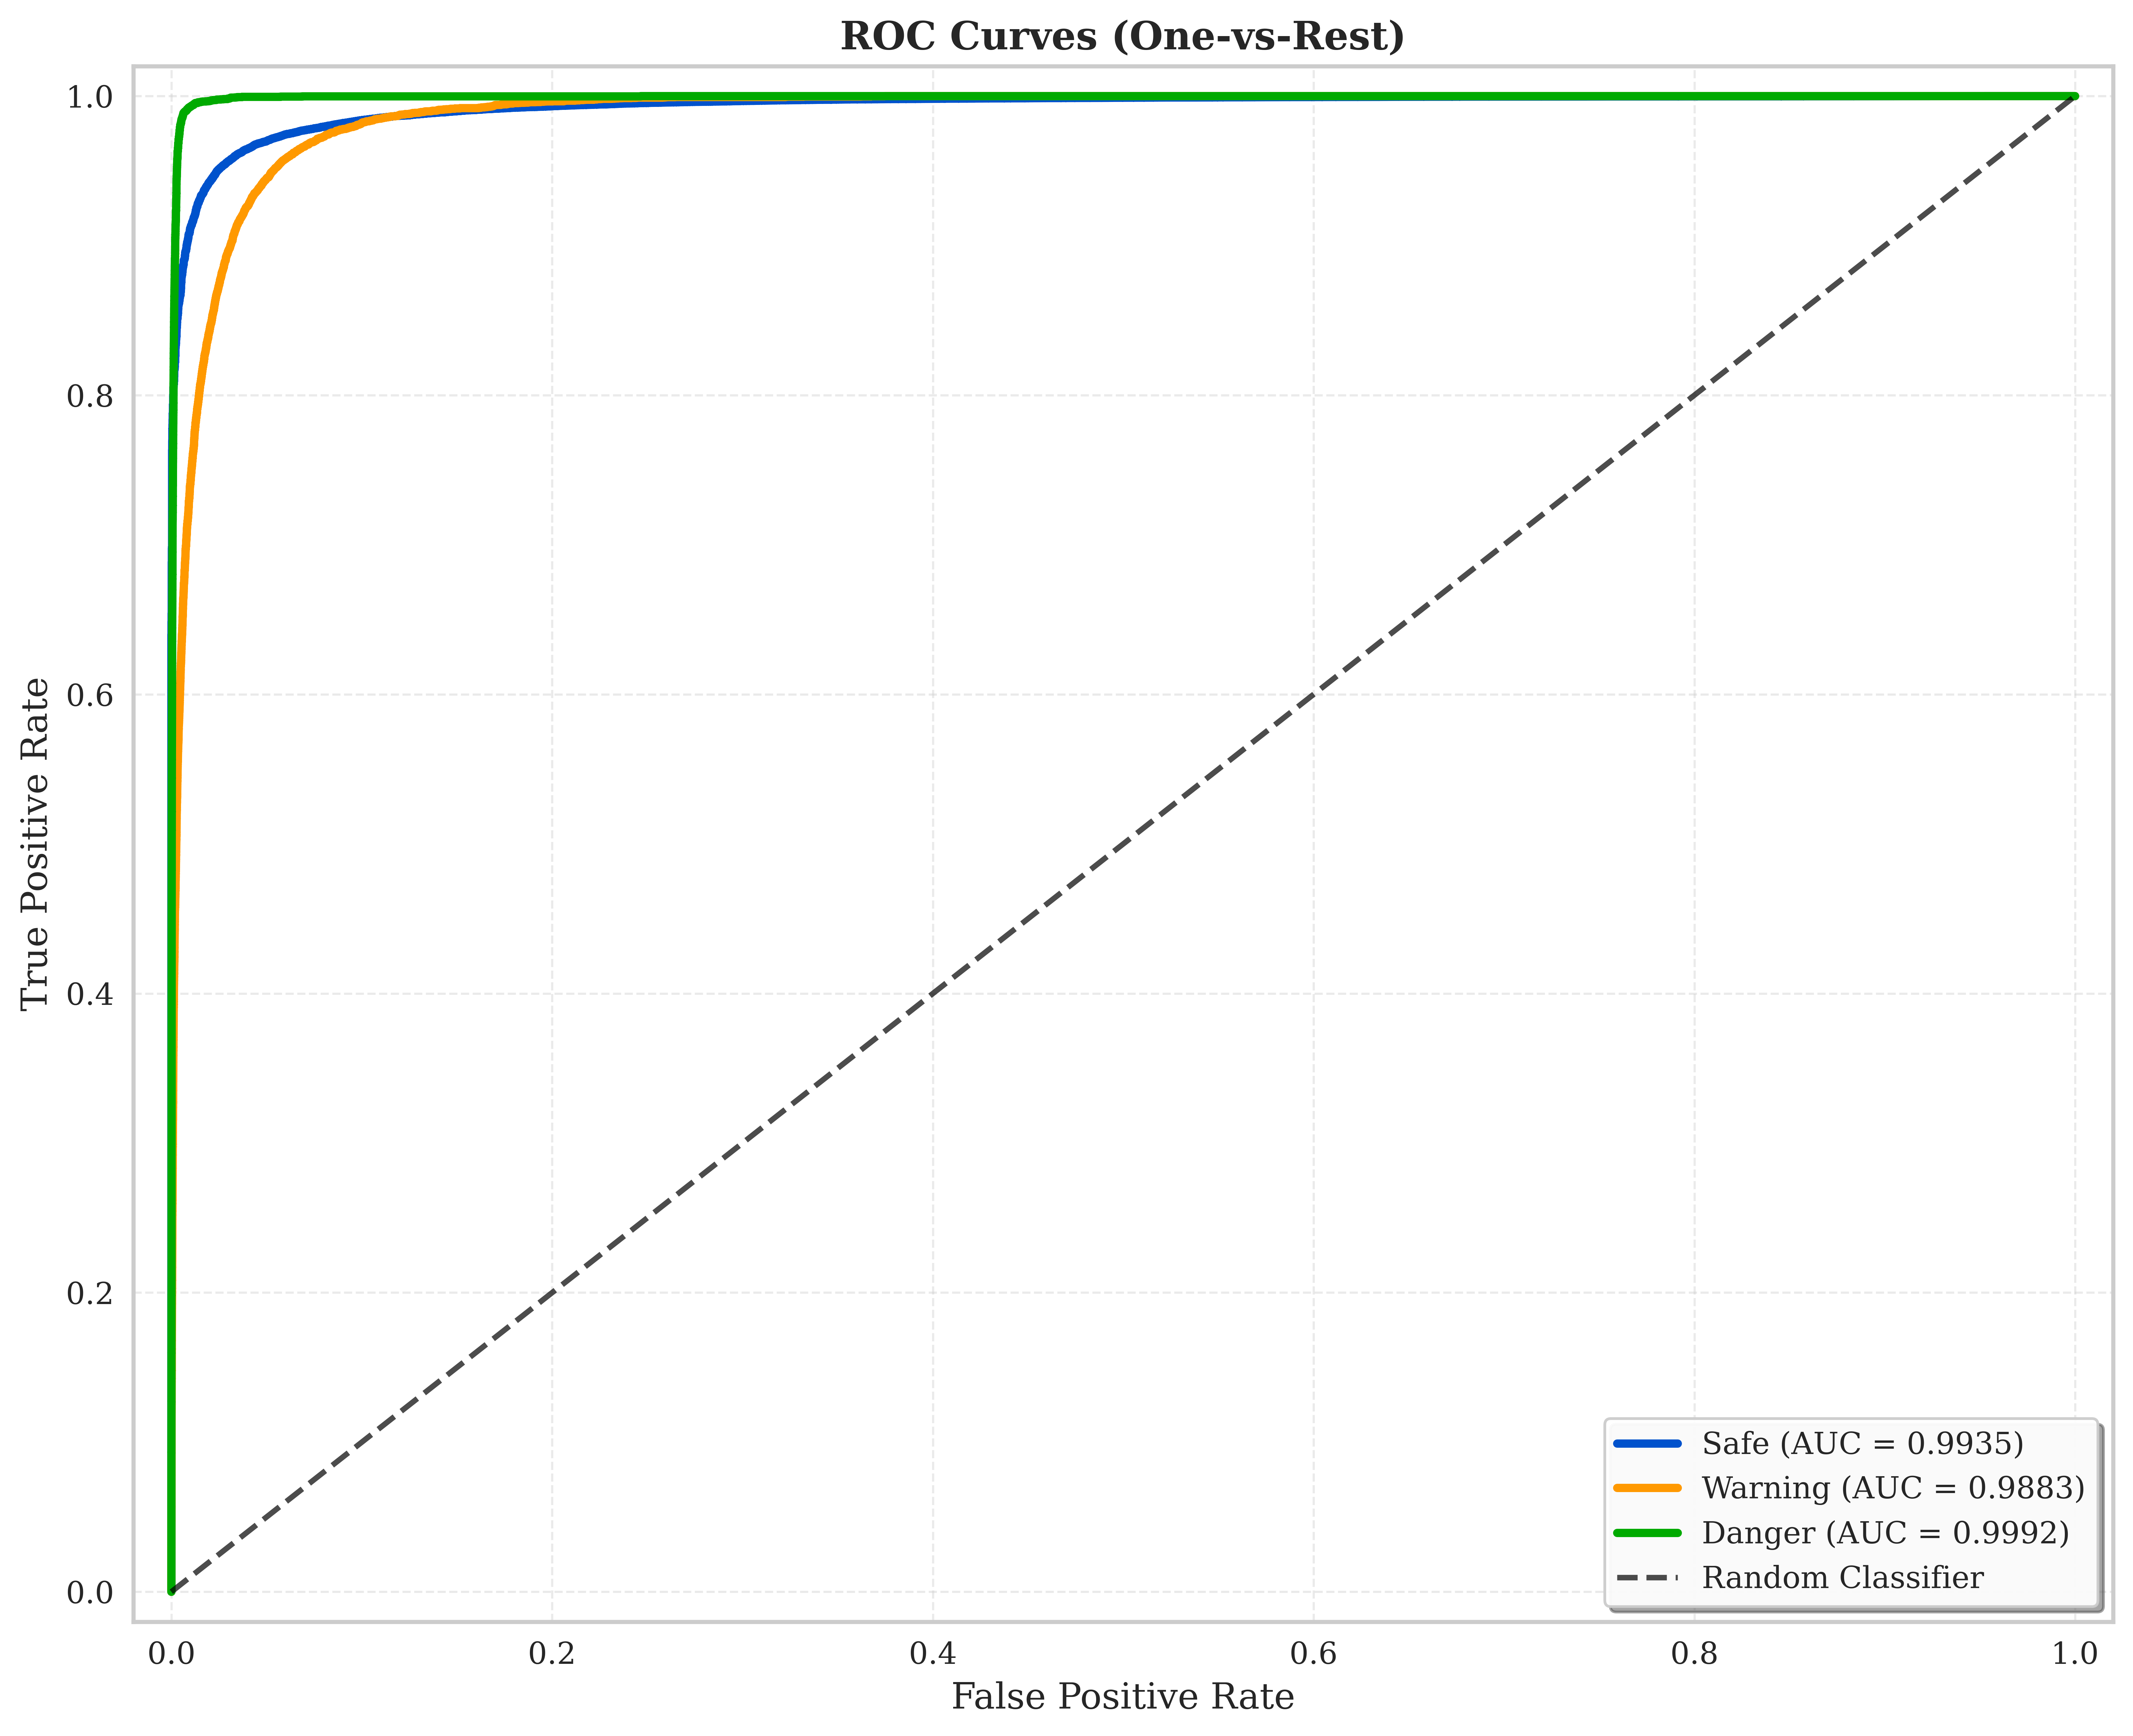


GENERATING COMPREHENSIVE ANALYSIS VISUALIZATIONS...



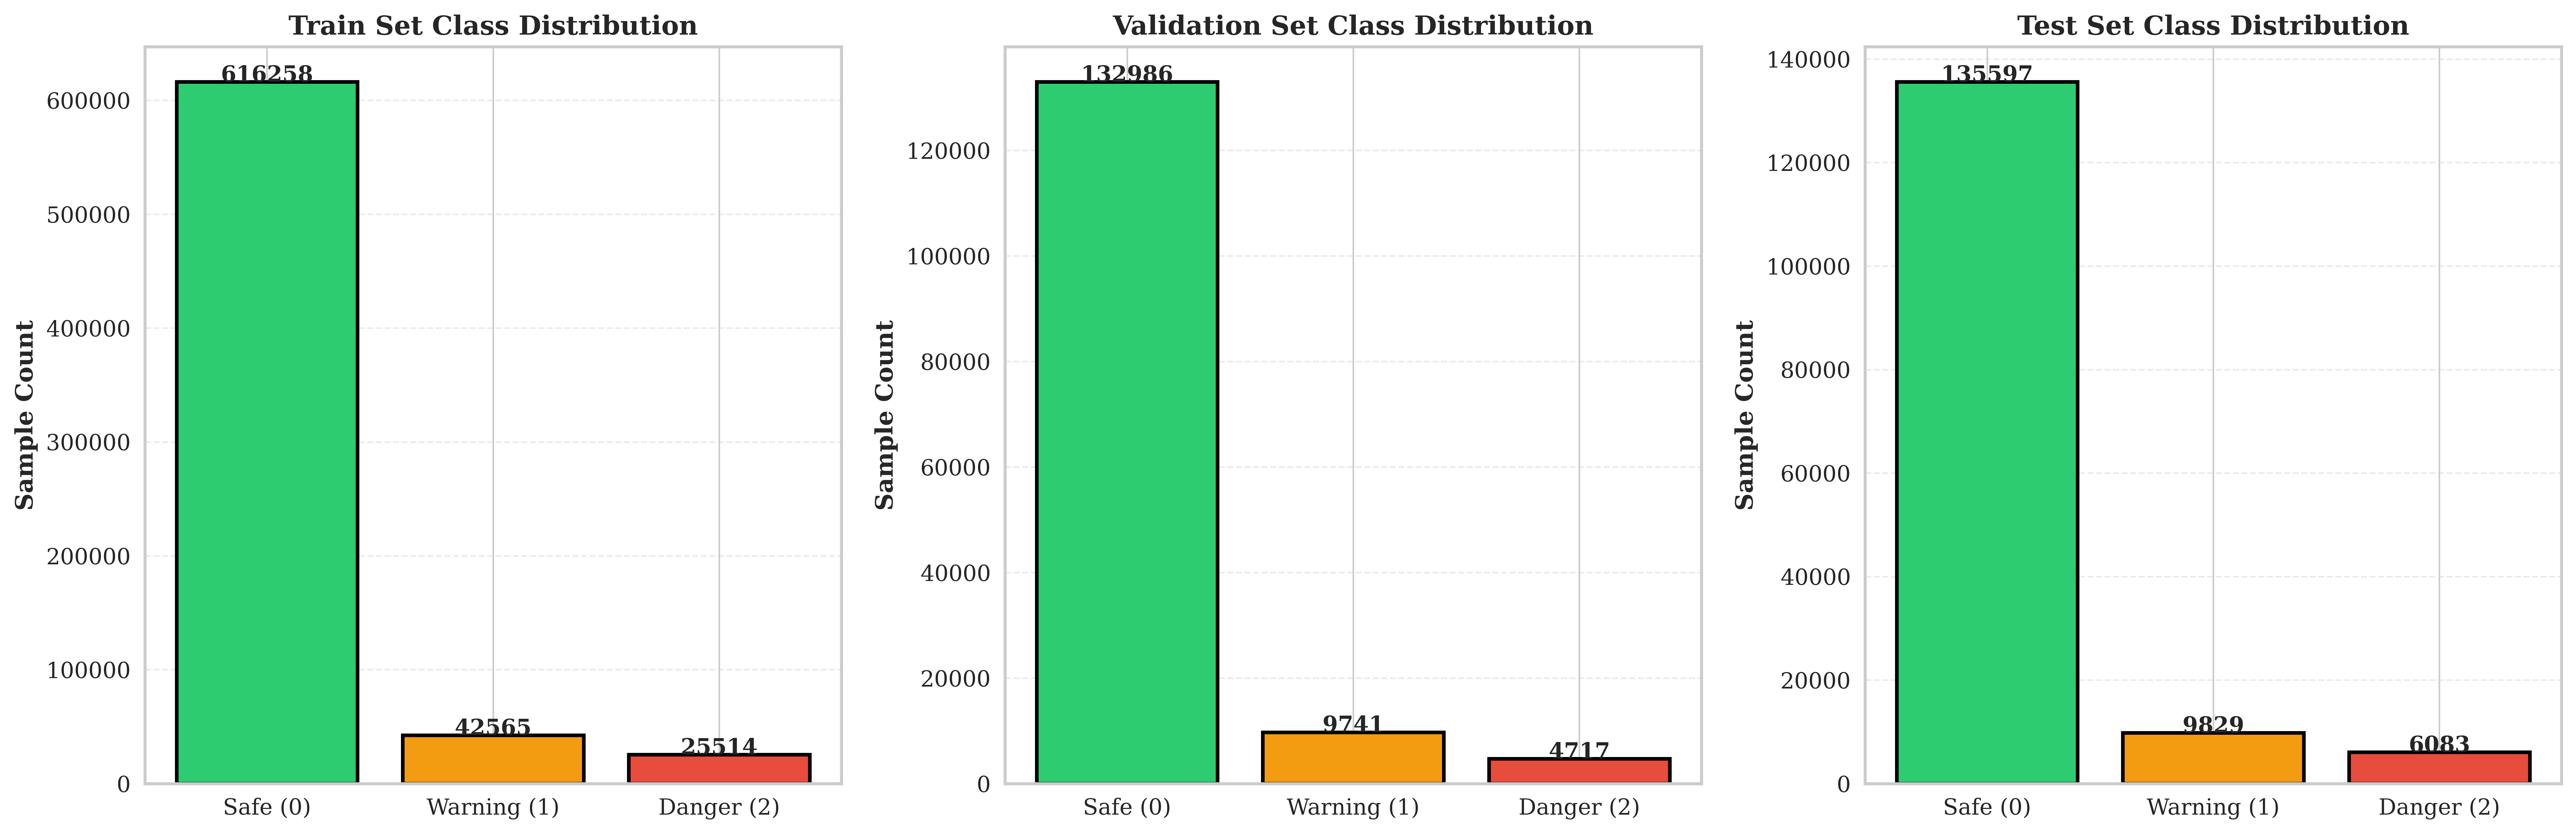

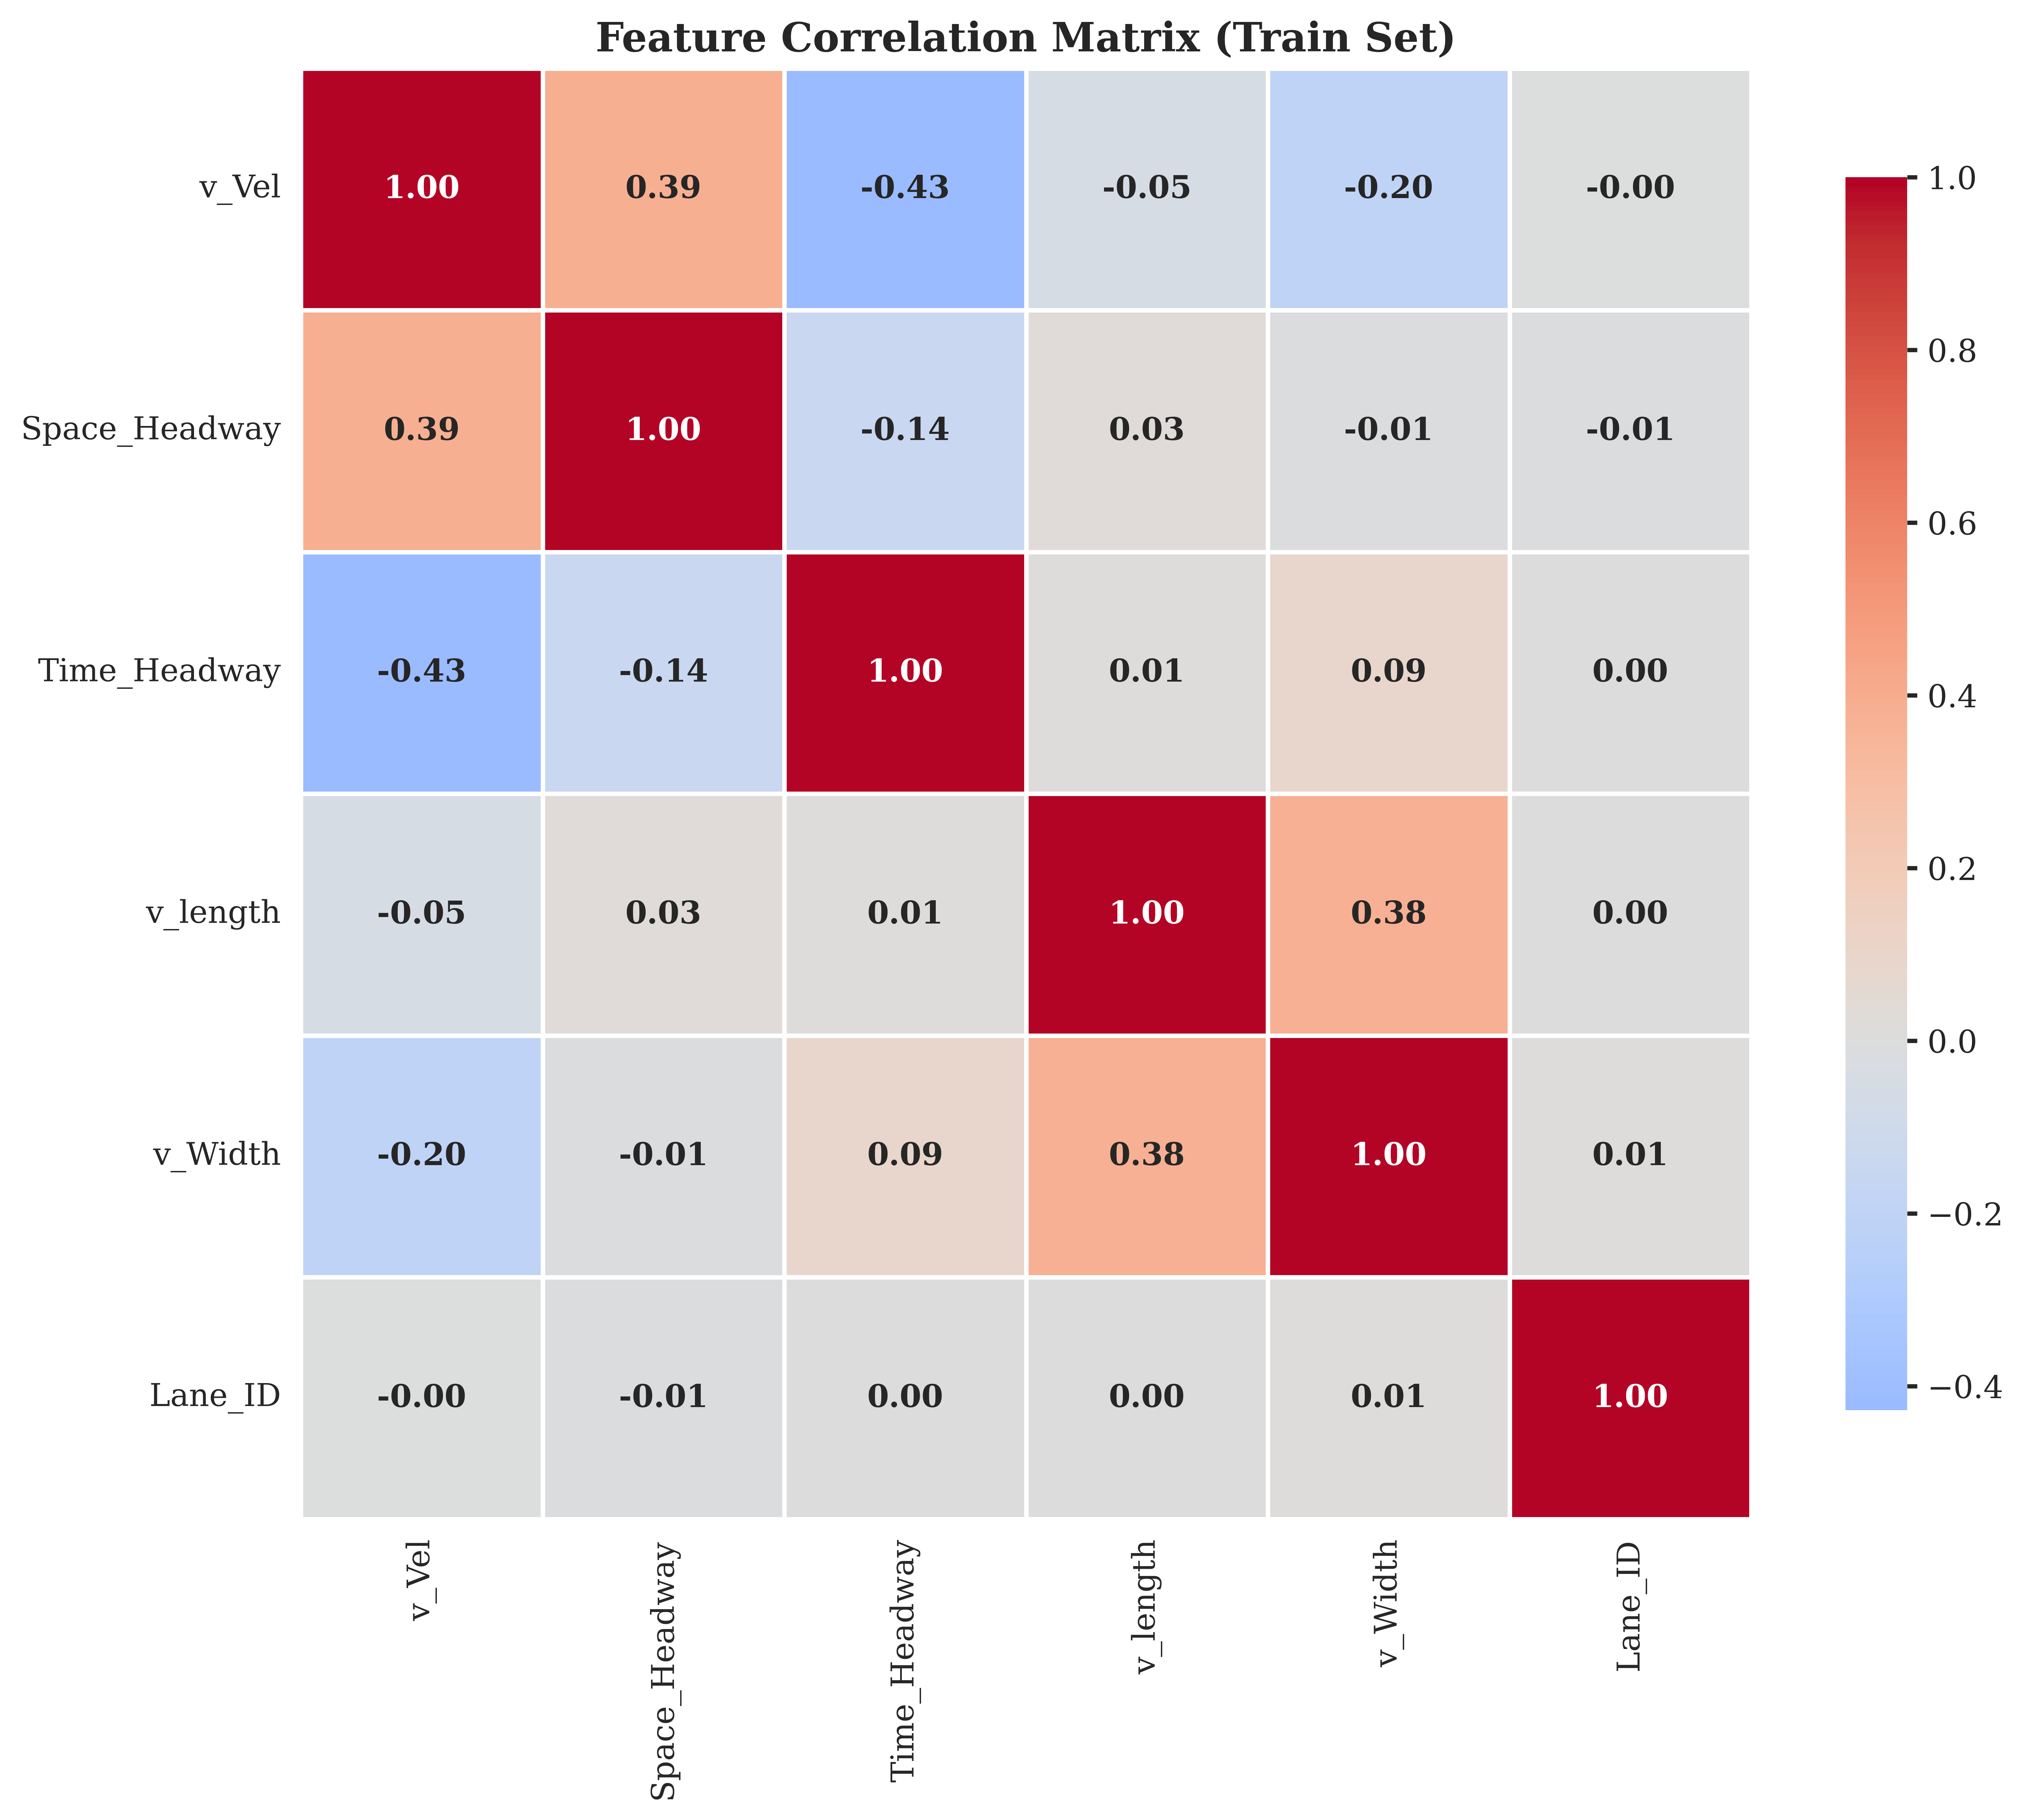

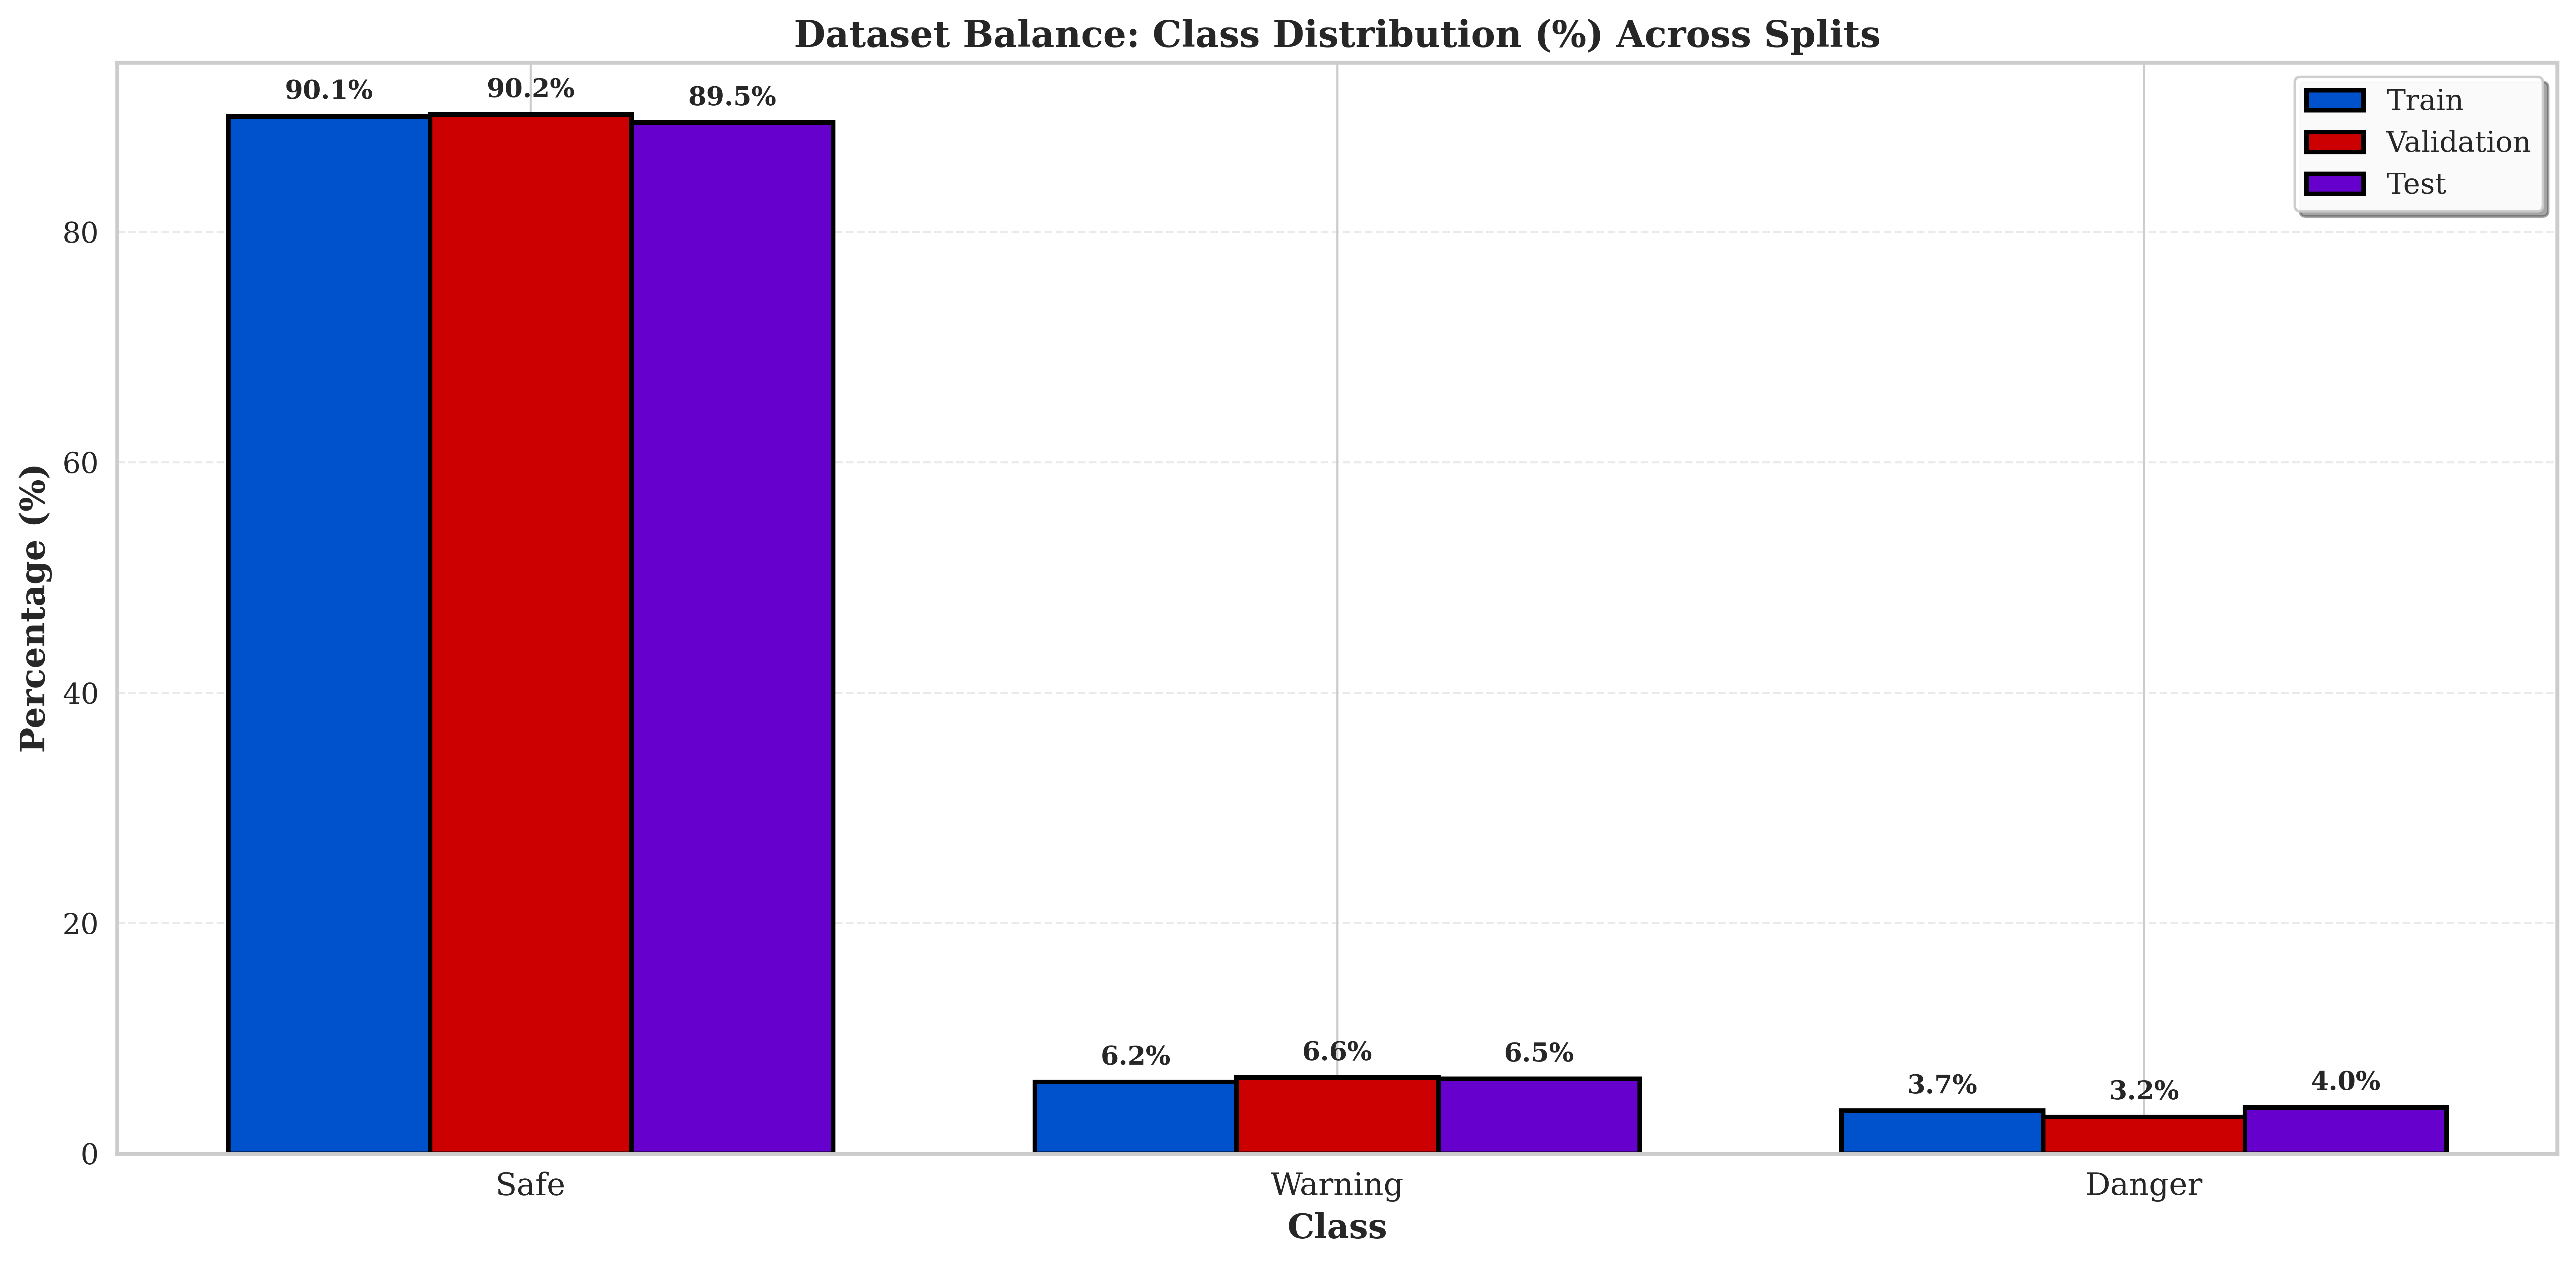


COMPREHENSIVE MODEL EVALUATION - TEST SET ANALYSIS

----------------------------------------------------------------------
CLASSIFICATION REPORT
----------------------------------------------------------------------
              precision    recall  f1-score   support

        Safe     0.9850    0.9876    0.9863    135597
     Warning     0.8188    0.7653    0.7911      9829
      Danger     0.9210    0.9637    0.9418      6083

    accuracy                         0.9722    151509
   macro avg     0.9082    0.9055    0.9064    151509
weighted avg     0.9716    0.9722    0.9718    151509


----------------------------------------------------------------------
CONFUSION MATRIX
----------------------------------------------------------------------
              Pred Safe  Pred Warning  Pred Danger
True Safe        133914          1516          167
True Warning       1971          7522          336
True Danger          72           149         5862

-------------------------------------

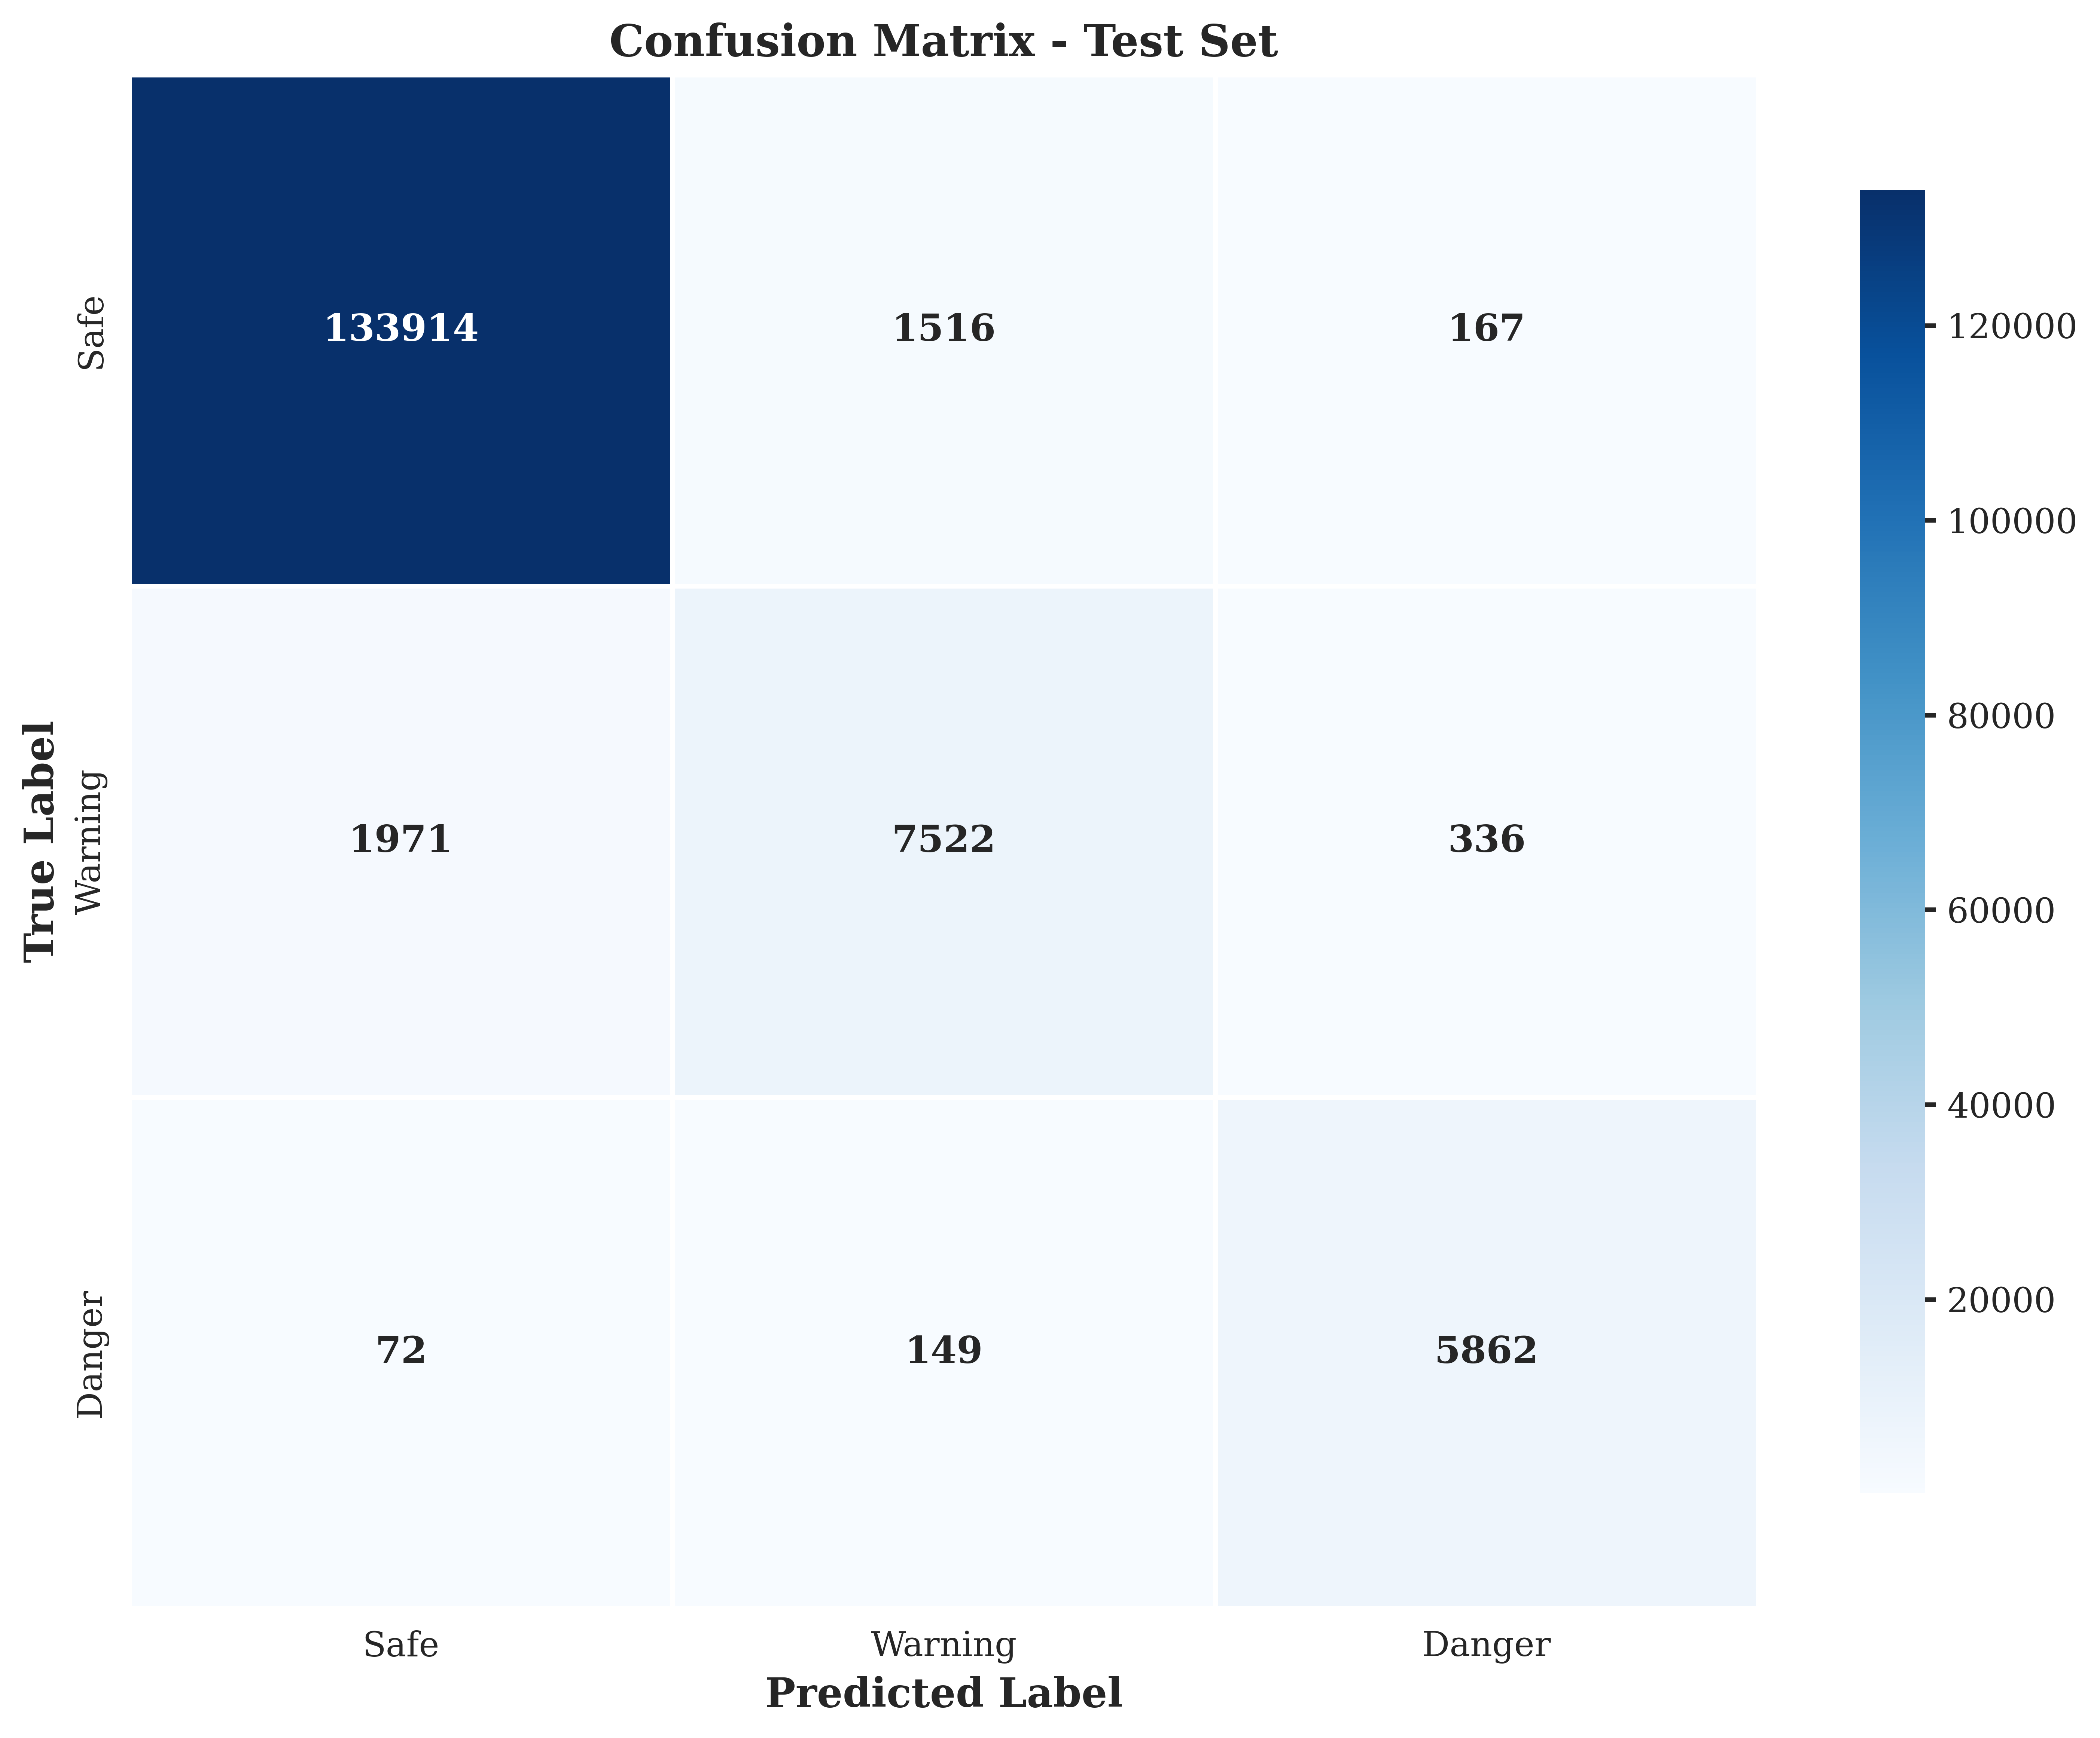


AUC METRICS SUMMARY - ROC-AUC ANALYSIS

Safe         (Class 0) | ROC-AUC Score: 0.9935
Warning      (Class 1) | ROC-AUC Score: 0.9883
Danger       (Class 2) | ROC-AUC Score: 0.9992

----------------------------------------------------------------------
MACRO-AVERAGE AUC: 0.9936
----------------------------------------------------------------------

  Class  Class_ID  AUC_Score
   Safe         0   0.993494
Warning         1   0.988299
 Danger         2   0.999151




In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report, precision_recall_fscore_support

import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, LSTM, Bidirectional,
    Dropout, BatchNormalization,
    Activation, Multiply, Lambda
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

import warnings
warnings.filterwarnings("ignore")

np.random.seed(42)
tf.random.set_seed(42)

# ============================================================
# MATPLOTLIB CONFIGURATION FOR HIGH-QUALITY RENDERING
# ============================================================
plt.rcParams['figure.dpi'] = 600
plt.rcParams['savefig.dpi'] = 600
plt.rcParams['font.size'] = 11
plt.rcParams['font.family'] = 'serif'
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['lines.linewidth'] = 2.5
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['xtick.major.width'] = 1.5
plt.rcParams['ytick.major.width'] = 1.5
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# ============================================================
#   COLLISION PREDICTION SYSTEM CLASS
# ============================================================

class CollisionPredictionSystem:
    def __init__(self, data_path, sequence_length=10,
                 prediction_horizon=1, smooth_window=10):
        self.data_path = data_path
        self.sequence_length = sequence_length
        self.prediction_horizon = prediction_horizon
        self.smooth_window = smooth_window

        self.scaler = StandardScaler()
        self.history = None

        # INPUT FEATURES (NO CIRCULAR FEATURES)
        self.feature_names = [
            'v_Vel', 'Space_Headway', 'Time_Headway',
            'v_length', 'v_Width', 'Lane_ID'
        ]

    # ============================================================
    # 1) LOAD RAW DATA (NO PROCESSING)
    # ============================================================
    def load_raw_data(self):
        df = pd.read_csv(self.data_path)

        if 'v_Class' in df.columns:
            df = df[df['v_Class'] == 2].copy()

        sort_col = 'Frame_ID' if 'Frame_ID' in df.columns else (
            'Global_Time' if 'Global_Time' in df.columns else None
        )
        if sort_col:
            df = df.sort_values(['Vehicle_ID', sort_col])

        self.df_raw = df.reset_index(drop=True)

    # ============================================================
    # 2) SPLIT FIRST (VEHICLE-WISE)
    # ============================================================
    def split_by_vehicle(self):
        vids = self.df_raw['Vehicle_ID'].unique()
        train_vids, temp_vids = train_test_split(
            vids, test_size=0.3, random_state=42
        )
        val_vids, test_vids = train_test_split(
            temp_vids, test_size=0.5, random_state=42
        )

        self.train_vids = set(train_vids)
        self.val_vids = set(val_vids)
        self.test_vids = set(test_vids)

    # ============================================================
    # 3) PROCESS EACH SPLIT INDEPENDENTLY
    # ============================================================
    def _process_split(self, df):
        df = df.copy()

        if 'Time_Headway' not in df.columns:
            df['Time_Headway'] = df['Space_Headway'] / (df['v_Vel'] + 1e-6)

        # Causal smoothing per vehicle
        for vid in df['Vehicle_ID'].unique():
            mask = df['Vehicle_ID'] == vid
            df.loc[mask, ['v_Vel', 'Space_Headway', 'Time_Headway']] = (
                df.loc[mask, ['v_Vel', 'Space_Headway', 'Time_Headway']]
                .rolling(self.smooth_window, min_periods=1)
                .mean()
            )

        # Label-only feature
        df['Inverse_Time_Gap'] = 1.0 / (df['Time_Headway'] + 1e-6)
        df.replace([np.inf, -np.inf], np.nan, inplace=True)

        df.dropna(subset=self.feature_names + ['Inverse_Time_Gap'], inplace=True)

        return df

    # ============================================================
    # 4) TRAIN-ONLY LABEL THRESHOLDS
    # ============================================================
    def _fit_label_thresholds(self, df_train):
        self.p90 = np.percentile(df_train['Inverse_Time_Gap'], 90)
        self.p99 = np.percentile(df_train['Inverse_Time_Gap'], 99)

    def _apply_labels(self, df):
        df = df.copy()
        df['collision_risk'] = 0
        df.loc[df['Inverse_Time_Gap'] >= self.p90, 'collision_risk'] = 1
        df.loc[df['Inverse_Time_Gap'] >= self.p99, 'collision_risk'] = 2
        return df

    # ============================================================
    # 5) FUTURE-RISK SEQUENCE CREATION (KEY FIX)
    # ============================================================
    def _create_sequences(self, df):
        X, y = [], []

        for vid in df['Vehicle_ID'].unique():
            sub = df[df['Vehicle_ID'] == vid]
            data = sub[self.feature_names].values.astype(np.float32)
            labels = sub['collision_risk'].values.astype(int)

            max_i = len(data) - self.sequence_length - self.prediction_horizon
            if max_i <= 0:
                continue

            for i in range(max_i):
                X.append(data[i:i + self.sequence_length])
                # FUTURE LABEL
                y.append(labels[i + self.sequence_length + self.prediction_horizon])

        return np.array(X), np.array(y)

    # ============================================================
    # BUILD DATASETS (ALL CLAIMS SATISFIED)
    # ============================================================
    def build_datasets(self):
        train_raw = self.df_raw[self.df_raw['Vehicle_ID'].isin(self.train_vids)]
        val_raw   = self.df_raw[self.df_raw['Vehicle_ID'].isin(self.val_vids)]
        test_raw  = self.df_raw[self.df_raw['Vehicle_ID'].isin(self.test_vids)]

        train_p = self._process_split(train_raw)
        val_p   = self._process_split(val_raw)
        test_p  = self._process_split(test_raw)

        self._fit_label_thresholds(train_p)

        train_l = self._apply_labels(train_p)
        val_l   = self._apply_labels(val_p)
        test_l  = self._apply_labels(test_p)

        # Store before scaling for analysis
        self.df_train_labeled = train_l.copy()
        self.df_val_labeled = val_l.copy()
        self.df_test_labeled = test_l.copy()

        self.scaler.fit(train_l[self.feature_names])
        for df in [train_l, val_l, test_l]:
            df[self.feature_names] = self.scaler.transform(df[self.feature_names])

        self.X_train, self.y_train = self._create_sequences(train_l)
        self.X_val, self.y_val     = self._create_sequences(val_l)
        self.X_test, self.y_test   = self._create_sequences(test_l)

    # ============================================================
    # MODEL (UNCHANGED)
    # ============================================================
    def build_model(self):
        inp = Input(shape=(self.sequence_length, len(self.feature_names)))

        x = Bidirectional(LSTM(128, return_sequences=True))(inp)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        x = Bidirectional(LSTM(64, return_sequences=True))(x)
        x = Dropout(0.3)(x)
        x = BatchNormalization()(x)

        e = Dense(64, activation='tanh')(x)
        e = Dense(1)(e)
        e = Lambda(lambda z: tf.squeeze(z, axis=-1))(e)
        alpha = Activation('softmax')(e)
        alpha = Lambda(lambda z: tf.expand_dims(z, axis=-1))(alpha)
        x = Multiply()([x, alpha])

        x = LSTM(32)(x)
        x = Dense(64, activation='relu')(x)
        x = Dense(32, activation='relu')(x)
        out = Dense(3, activation='softmax')(x)

        model = Model(inp, out)
        model.compile(
            optimizer=Adam(1e-4),
            loss='categorical_crossentropy',
            metrics=['accuracy']
        )
        return model

    # ============================================================
    # TRAIN, SUMMARY, CURVES, ROC
    # ============================================================
    def train(self, epochs=50):
        self.model = self.build_model()

        self.history = self.model.fit(
            self.X_train,
            to_categorical(self.y_train, 3),
            validation_data=(self.X_val, to_categorical(self.y_val, 3)),
            epochs=epochs,
            batch_size=64,
            callbacks=[
                EarlyStopping(patience=10, restore_best_weights=True),
                ReduceLROnPlateau(patience=5)
            ],
            verbose=1
        )

        self.print_training_summary()
        self.plot_training_curves()
        self.plot_roc_auc()

    def print_training_summary(self):
        h = self.history.history
        print("\n========== TRAINING SUMMARY ==========")
        print(f"Epochs Trained        : {len(h['loss'])}")
        print(f"Final Train Accuracy  : {h['accuracy'][-1]*100:.2f}%")
        print(f"Final Val Accuracy    : {h['val_accuracy'][-1]*100:.2f}%")
        print(f"Final Train Loss      : {h['loss'][-1]:.4f}")
        print(f"Final Val Loss        : {h['val_loss'][-1]:.4f}")
        print("=====================================\n")

    def plot_training_curves(self):
        h = self.history.history
        epochs = range(1, len(h['accuracy']) + 1)

        fig = plt.figure(figsize=(18, 6), dpi=600)

        # Accuracy plot
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, np.array(h['accuracy']) * 100, label='Train Accuracy', color='#0052CC', linewidth=2.8, marker='o', markersize=4, markevery=5)
        ax1.plot(epochs, np.array(h['val_accuracy']) * 100, label='Val Accuracy', color='#CC0000', linewidth=2.8, marker='s', markersize=4, markevery=5)
        ax1.set_xlabel('Number of Epochs', fontsize=13)
        ax1.set_ylabel('Accuracy (%)', fontsize=13)
        ax1.set_title('AG-BiLSTM Training & Validation Accuracy', fontsize=14, fontweight='bold')
        ax1.legend(loc='lower right', framealpha=0.95, fancybox=True, shadow=True)
        ax1.grid(alpha=0.4, linestyle='--', linewidth=0.8)
        ax1.set_ylim([94, 99])

        # Loss plot
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(epochs, h['loss'], label='Train Loss', color='#0052CC', linewidth=2.8, marker='o', markersize=4, markevery=5)
        ax2.plot(epochs, h['val_loss'], label='Val Loss', color='#CC0000', linewidth=2.8, marker='s', markersize=4, markevery=5)
        ax2.set_xlabel('Number of Epochs', fontsize=13)
        ax2.set_ylabel('Loss', fontsize=13)
        ax2.set_title('AG-BiLSTM Training & Validation Loss', fontsize=14, fontweight='bold')
        ax2.legend(loc='upper right', framealpha=0.95, fancybox=True, shadow=True)
        ax2.grid(alpha=0.4, linestyle='--', linewidth=0.8)

        plt.tight_layout(pad=1.5)
        plt.savefig('training_curves.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    def plot_roc_auc(self):
        y_prob = self.model.predict(self.X_test, verbose=0)
        labels = ['Safe', 'Warning', 'Danger']
        colors = ['#0052CC', '#FF9900', '#00AA00']

        fig = plt.figure(figsize=(11, 9), dpi=600)
        ax = plt.gca()

        for i in range(3):
            y_bin = (self.y_test == i).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, lw=3, label=f'{labels[i]} (AUC = {roc_auc:.4f})',
                   color=colors[i])

        ax.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier', alpha=0.7)
        ax.set_xlabel('False Positive Rate', fontsize=13)
        ax.set_ylabel('True Positive Rate', fontsize=13)
        ax.set_title('ROC Curves (One-vs-Rest)', fontsize=14, fontweight='bold')
        ax.legend(loc='lower right', framealpha=0.95, fancybox=True, shadow=True, fontsize=11)
        ax.grid(alpha=0.4, linestyle='--', linewidth=0.8)
        ax.set_xlim([-0.02, 1.02])
        ax.set_ylim([-0.02, 1.02])

        plt.tight_layout(pad=1.5)
        plt.savefig('roc_curves.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: FEATURE MATRIX DISTRIBUTION
    # ============================================================
    def plot_feature_distribution(self):
        df_plot = self.df_train_labeled[self.feature_names].copy()

        fig = plt.figure(figsize=(20, 12), dpi=600)
        for idx, feature in enumerate(self.feature_names, 1):
            plt.subplot(2, 3, idx)
            plt.hist(df_plot[feature], bins=60, color='#0052CC', alpha=0.8, edgecolor='black', linewidth=1.2)
            plt.xlabel(feature, fontsize=12, fontweight='bold')
            plt.ylabel('Frequency', fontsize=12, fontweight='bold')
            plt.title(f'Distribution: {feature}', fontsize=13, fontweight='bold')
            plt.grid(alpha=0.4, axis='y', linestyle='--')

        plt.tight_layout(pad=1.5)
        plt.savefig('feature_distribution.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: CLASS DISTRIBUTION ANALYSIS
    # ============================================================
    def plot_class_distribution(self):
        class_labels = ['Safe (0)', 'Warning (1)', 'Danger (2)']
        colors = ['#2ecc71', '#f39c12', '#e74c3c']

        fig, axes = plt.subplots(1, 3, figsize=(18, 6), dpi=600)

        # Train set
        train_counts = np.bincount(self.y_train, minlength=3)
        axes[0].bar(class_labels, train_counts, color=colors, edgecolor='black', linewidth=1.8)
        axes[0].set_title('Train Set Class Distribution', fontsize=13, fontweight='bold')
        axes[0].set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        for i, v in enumerate(train_counts):
            axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold', fontsize=11)
        axes[0].grid(alpha=0.4, axis='y', linestyle='--')

        # Validation set
        val_counts = np.bincount(self.y_val, minlength=3)
        axes[1].bar(class_labels, val_counts, color=colors, edgecolor='black', linewidth=1.8)
        axes[1].set_title('Validation Set Class Distribution', fontsize=13, fontweight='bold')
        axes[1].set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        for i, v in enumerate(val_counts):
            axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=11)
        axes[1].grid(alpha=0.4, axis='y', linestyle='--')

        # Test set
        test_counts = np.bincount(self.y_test, minlength=3)
        axes[2].bar(class_labels, test_counts, color=colors, edgecolor='black', linewidth=1.8)
        axes[2].set_title('Test Set Class Distribution', fontsize=13, fontweight='bold')
        axes[2].set_ylabel('Sample Count', fontsize=12, fontweight='bold')
        for i, v in enumerate(test_counts):
            axes[2].text(i, v + 50, str(v), ha='center', fontweight='bold', fontsize=11)
        axes[2].grid(alpha=0.4, axis='y', linestyle='--')

        plt.tight_layout(pad=1.5)
        plt.savefig('class_distribution.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: FEATURE CORRELATION MATRIX
    # ============================================================
    def plot_correlation_matrix(self):
        df_corr = self.df_train_labeled[self.feature_names].copy()
        corr_matrix = df_corr.corr()

        fig = plt.figure(figsize=(11, 9), dpi=600)
        sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
                    center=0, square=True, linewidths=1.5, cbar_kws={"shrink": 0.85},
                    annot_kws={'fontsize': 11, 'fontweight': 'bold'})
        plt.title('Feature Correlation Matrix (Train Set)', fontsize=14, fontweight='bold')
        plt.tight_layout(pad=1.5)
        plt.savefig('correlation_matrix.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: DATASET BALANCE ANALYSIS
    # ============================================================
    def plot_dataset_balance(self):
        class_labels = ['Safe', 'Warning', 'Danger']

        train_dist = np.bincount(self.y_train, minlength=3) / len(self.y_train) * 100
        val_dist = np.bincount(self.y_val, minlength=3) / len(self.y_val) * 100
        test_dist = np.bincount(self.y_test, minlength=3) / len(self.y_test) * 100

        x = np.arange(len(class_labels))
        width = 0.25

        fig = plt.figure(figsize=(14, 7), dpi=600)
        ax = plt.gca()

        bars1 = ax.bar(x - width, train_dist, width, label='Train', color='#0052CC', edgecolor='black', linewidth=1.8)
        bars2 = ax.bar(x, val_dist, width, label='Validation', color='#CC0000', edgecolor='black', linewidth=1.8)
        bars3 = ax.bar(x + width, test_dist, width, label='Test', color='#6600CC', edgecolor='black', linewidth=1.8)

        ax.set_xlabel('Class', fontsize=13, fontweight='bold')
        ax.set_ylabel('Percentage (%)', fontsize=13, fontweight='bold')
        ax.set_title('Dataset Balance: Class Distribution (%) Across Splits', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(class_labels, fontsize=12)
        ax.legend(fontsize=11, framealpha=0.95, fancybox=True, shadow=True)
        ax.grid(alpha=0.4, axis='y', linestyle='--')

        for i in range(3):
            ax.text(i - width, train_dist[i] + 1.5, f'{train_dist[i]:.1f}%', ha='center', fontsize=10, fontweight='bold')
            ax.text(i, val_dist[i] + 1.5, f'{val_dist[i]:.1f}%', ha='center', fontsize=10, fontweight='bold')
            ax.text(i + width, test_dist[i] + 1.5, f'{test_dist[i]:.1f}%', ha='center', fontsize=10, fontweight='bold')

        plt.tight_layout(pad=1.5)
        plt.savefig('dataset_balance.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: COMPREHENSIVE MODEL EVALUATION
    # ============================================================
    def comprehensive_model_evaluation(self):
        y_pred_prob = self.model.predict(self.X_test, verbose=0)
        y_pred = np.argmax(y_pred_prob, axis=1)

        class_names = ['Safe', 'Warning', 'Danger']

        print("\n" + "="*70)
        print("COMPREHENSIVE MODEL EVALUATION - TEST SET ANALYSIS")
        print("="*70)

        print("\n" + "-"*70)
        print("CLASSIFICATION REPORT")
        print("-"*70)
        print(classification_report(self.y_test, y_pred, target_names=class_names, digits=4))

        # Confusion Matrix
        cm = confusion_matrix(self.y_test, y_pred)

        print("\n" + "-"*70)
        print("CONFUSION MATRIX")
        print("-"*70)
        cm_df = pd.DataFrame(cm, index=[f'True {name}' for name in class_names],
                            columns=[f'Pred {name}' for name in class_names])
        print(cm_df)

        # Per-class metrics
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_test, y_pred)

        print("\n" + "-"*70)
        print("PER-CLASS DETAILED METRICS")
        print("-"*70)
        for i, class_name in enumerate(class_names):
            print(f"{class_name:12s} | Precision: {precision[i]:.4f} | Recall: {recall[i]:.4f} | F1-Score: {f1[i]:.4f}")

        # Calculate overall metrics
        overall_precision = np.mean(precision)
        overall_recall = np.mean(recall)
        overall_f1 = np.mean(f1)

        # Calculate weighted average metrics
        class_counts = np.bincount(self.y_test)
        total_samples = np.sum(class_counts)
        weights = class_counts / total_samples

        weighted_precision = np.sum(precision * weights)
        weighted_recall = np.sum(recall * weights)
        weighted_f1 = np.sum(f1 * weights)

        print("\n" + "-"*70)
        print("OVERALL METRICS (MACRO-AVERAGE)")
        print("-"*70)
        print(f"{'Overall':12s} | Precision: {overall_precision:.4f} | Recall: {overall_recall:.4f} | F1-Score: {overall_f1:.4f}")

        print("\n" + "-"*70)
        print("OVERALL METRICS (WEIGHTED-AVERAGE)")
        print("-"*70)
        print(f"{'Weighted':12s} | Precision: {weighted_precision:.4f} | Recall: {weighted_recall:.4f} | F1-Score: {weighted_f1:.4f}")

        # Overall accuracy
        accuracy = np.sum(y_pred == self.y_test) / len(self.y_test)
        print("\n" + "-"*70)
        print(f"OVERALL ACCURACY: {accuracy*100:.2f}%")
        print("-"*70 + "\n")

        # Visualize Confusion Matrix
        fig = plt.figure(figsize=(10, 8), dpi=600)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar_kws={"shrink": 0.85}, linewidths=1.5, annot_kws={'fontsize': 12, 'fontweight': 'bold'})
        plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
        plt.ylabel('True Label', fontsize=13, fontweight='bold')
        plt.xlabel('Predicted Label', fontsize=13, fontweight='bold')
        plt.tight_layout(pad=1.5)
        plt.savefig('confusion_matrix.png', dpi=600, bbox_inches='tight', facecolor='white')
        plt.show()

    # ============================================================
    # NEW: AUC METRICS SUMMARY
    # ============================================================
    def print_auc_metrics_summary(self):
        y_prob = self.model.predict(self.X_test, verbose=0)
        class_names = ['Safe', 'Warning', 'Danger']

        print("\n" + "="*70)
        print("AUC METRICS SUMMARY - ROC-AUC ANALYSIS")
        print("="*70 + "\n")

        auc_scores = []
        for i, class_name in enumerate(class_names):
            y_bin = (self.y_test == i).astype(int)
            fpr, tpr, _ = roc_curve(y_bin, y_prob[:, i])
            roc_auc = auc(fpr, tpr)
            auc_scores.append(roc_auc)
            print(f"{class_name:12s} (Class {i}) | ROC-AUC Score: {roc_auc:.4f}")

        mean_auc = np.mean(auc_scores)
        print("\n" + "-"*70)
        print(f"MACRO-AVERAGE AUC: {mean_auc:.4f}")
        print("-"*70 + "\n")

        # Summary table
        summary_df = pd.DataFrame({
            'Class': class_names,
            'Class_ID': [0, 1, 2],
            'AUC_Score': auc_scores
        })
        print(summary_df.to_string(index=False))
        print("\n")


# ============================================================
# MAIN
# ============================================================
def main():
    system = CollisionPredictionSystem(
        data_path="/content/drive/MyDrive/BiLSTM/NGSIM.csv",
        sequence_length=10,
        prediction_horizon=1
    )

    system.load_raw_data()
    system.split_by_vehicle()
    system.build_datasets()
    system.train(epochs=50)

    # NEW ANALYSIS VISUALIZATIONS
    print("\n" + "="*70)
    print("GENERATING COMPREHENSIVE ANALYSIS VISUALIZATIONS...")
    print("="*70 + "\n")

    system.plot_feature_distribution()
    system.plot_class_distribution()
    system.plot_correlation_matrix()
    system.plot_dataset_balance()
    system.comprehensive_model_evaluation()
    system.print_auc_metrics_summary()


if __name__ == "__main__":
    main()